# FreeTrace tutorial

# Requirements
FreeTrace requires Linux platform to infer the molecular trajectories from microscopy video.</br>
- Linux (python3.10&uarr;) with GPU (Cuda).</br>
- Cuda installation: [Nvidia Cuda installation](https://developer.nvidia.com/cuda-toolkit)</br>
You can run FreeTrace without GPU, however it infers the trajectory under standard Brownian motion rather than fractional Brownian motion.</br>
In the case of high molecular density in heterogenous medium, we recommend you to run FreeTrace with GPU equipped machine for the best inference result.

# FreeTrace installation
After donwload FreeTrace via pip, the import of FreeTrace.installation will download additional DNN models, packages and compile the C codes which are mandatory to run the FreeTrace. If you don't want to upgrade your python packages to the latest version, please install it manually. The required packaged is enumerated in the requirements.txt.</br>
FreeTrace utilizes tensorflow 2.14/2.17 to run it with sourcecode. Without GPU, FreeTrace doesn't need Tensorflow and infer the trajectories under standard Brownian motion. Once the installation is succesfully finished, you don't need to re-import the FreeTrace.installation for each inference.

In [1]:
!pip3 install FreeTrace
import FreeTrace.installation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.2/595.2 kB 15.3 MB/s eta 0:00:00m eta 0:00:01
***** FreeTrace needs Cuda. if Cuda is not installed, please visit [https://developer.nvidia.com/cuda-downloads?target_os=Linux&target_arch=x86_64&Distribution=Ubuntu&target_version=24.04&target_type=deb_network] *****
***** FreeTrace includes the installation of below items. *****
numpy numba networkx pandas seaborn tables scikit-learn scikit-image scipy opencv-python matplotlib imageio tifffile roifile pillow tqdm cupy-cuda12x PyQt6 tensorflow[and-cuda]==2.17
unzip clang python3-tk python3-dev python3-pip

If you don't want to continue, please stop the process.


KeyboardInterrupt: 

# FreeTrace algorithm

FreeTrace is consist of two major algorithms.
- Localization of particles from video.</br>
- Reconnection of particles over time.</br>
The units of FreeTrace output are pixel (coordinate) and frame (time). To analyse the result with your microscopy setting, you need to convert the data into micrometer/nanometer and miliseconds.</br>

The detailed algorithm of FreeTrace will be available soon.

# 1. Parameter settings
Below is pre-defined parameters to run FreeTrace.</br>

In [1]:
from FreeTrace import Tracking, Localization

video_name = 'inputs/sample0.tiff'  # input video.tiff path.
output_dir = 'outputs'  # output path.
verbose = 1  # print ETA of process if verbose=1, 0 otherwise.

window_size = 7  # Length (pixel) of sliding window to localize molecules from video
threshold = 1.0  # Threshold factor to determine the existence of molecule inside sliding windows, base thresholds are calculated with SNR of images.
realtime_localization = False  # Real time visulaization of localization if True, False otherwise.
gpu_for_localization = True  # GPU acceleration of localization if True, False otherwise.
save_localization_video = False  # Save the visualized localization in tiff format.

time_forecast = 2  # Number of frames for the inference of trajectories at each step, between 1 and 10. Higher number will slow down the speed.
cutoff = 3  # Minimum length of trajectory for the output.
jump_threshold = None  # Maximum jump length of molecules for each frame. If None, FreeTrace estimate it automatically with GMM.
realtime_tracking = False  # Real time visulaization of tracking if True, False otherwise.
gpu_for_tracking = True  # Tracking under fBm if True. otherwise, FreeTrace infers the trajectories with standard Brownian motion.
save_tracking_video = False  # Save the visualized trajectories in tiff format.

# 2. Localization

- Run the localization of molecules from video with pre-difined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [2]:
loc = Localization.run_process(input_video_path=video_name,
                               output_path=output_dir,
                               window_size=window_size,
                               threshold=threshold,
                               gpu_on=gpu_for_localization,
                               save_video=save_localization_video, 
                               realtime_visualization=realtime_localization,
                               verbose=verbose)

2025-05-27 12:16:18.093446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 12:16:18.103207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 12:16:18.106208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 12:16:18.114516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 12:16:18.858942: W tensorflow/compiler/tf2


******************************** OPTIONS *****************************************
**** Cuda: Ok, Tensorflow: Ok, Localization performs fast/complete inferences. ***
**********************************************************************************



I0000 00:00:1748340979.356345   19482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748340979.396418   19482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748340979.396515   19482 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
Localization: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.72frame/s]


# 3. Trajectory inference

- Run the tracking of localized molecules from video and localization results, with pre-defined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [3]:
track = Tracking.run_process(input_video_path=video_name,
                             output_path=output_dir,
                             time_forecast=time_forecast,
                             cutoff=cutoff,
                             jump_threshold=jump_threshold,
                             gpu_on=gpu_for_tracking,
                             save_video=save_tracking_video,
                             realtime_visualization=realtime_tracking,
                             verbose=verbose)

2025-05-27 12:16:22.787914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 12:16:22.797635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 12:16:22.800572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 12:16:22.808494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 12:16:23.519696: W tensorflow/compiler/tf2


******************************** OPTIONS *****************************************
***** Cuda: Ok, Tensorflow: Ok, Tracking performs slow/complete inferences. ******
**********************************************************************************



I0000 00:00:1748340983.996268   19598 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748340984.017227   19598 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748340984.017320   19598 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748340984.106195   19598 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748340984.106297   19598 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Mean nb of particles per frame: 19.03 particles/frame


Tracking:   0%|                                                                              | 0/100 [00:00<?, ?frame/s]/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Tracking:   6%|████▏                                                                 | 6/100 [00:00<00:02, 38.83frame/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1748340991.443880   19692 service.cc:146] XLA service 0x448770f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748340991.443918   19692 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-27 12:16:31.456190: I external/

Once the localization and tracking of FreeTrace finish succesfully, you can find the molecular trajectory file in your output directory with the name <b>video_traces.csv</b>.</br></br>
If your trajectory is heterogeneous, you need an additional external software to segment the trajectory.</br>
Below is the simple analysis steps of trajectory data, we assumed that your trajectory is homogeneous or already segmented with your preferred software.</br>

# 4. Load trajectory data

In [4]:
from FreeTrace.module.data_load import read_csv, read_multiple_csv
trajectory_data = read_csv(file='outputs/sample0_traces.csv')
#trajectory_data = read_multiple_csv('outputs')
trajectory_data

,traj_idx,frame,x,y,z,state
0,0,26,76.694749,54.818897,6.899004e-310,0
1,0,28,75.835419,54.806431,6.899004e-310,0
2,0,29,73.202596,52.991906,5.040637e-315,0
3,1,19,36.141905,69.111857,5.040637e-315,0
4,1,20,36.201043,69.883163,9.881313e-323,0
...,...,...,...,...,...,...
1650,173,69,82.615350,81.268227,3.409053e-322,0
1651,174,26,40.962664,36.797368,1.284571e-322,0
1652,174,28,43.257812,37.964984,1.383384e-322,0
1653,174,29,41.849590,36.118522,1.432790e-322,0


# 5. Simple analysis of trajectory

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from FreeTrace.module.preprocessing import simple_preprocessing

"""
Option settings for data analysis.
"""
PIXELMICRONS = 0.16
FRAMERATE = 0.01
CUTOFF = 3  # miminum length of trajectory to conisder for the analysis.
number_of_bins = 50
figure_resolution_in_dpi = 200
figure_font_size = 20


"""
preprocessing generates 4 data.
@params: data folder path, pixel microns, frame rate, cutoff
@output: Analysis_data1(pd.DataFrame), Analysis_data2(pd.DataFrame), MSD(pd.DataFrame), TAMSD(pd.DataFrame)

Simple_preprocessing includes below steps.
1. exclude the trajectory where length is shorter than CUTOFF
2. convert from pixel unit to micrometer unit with PIXELMICRONS and FRAMERATE
3. generate 4 DataFrames.
"""
analysis_data1, analysis_data2, analysis_data3, msd, tamsd = simple_preprocessing(data=trajectory_data,
                                                                                  pixelmicrons=PIXELMICRONS,
                                                                                  framerate=FRAMERATE,
                                                                                  cutoff=CUTOFF)

print(f'\nanalysis_data1:\n', analysis_data1)
print(f'\nanalysis_data2:\n', analysis_data2)
print(f'\nanalysis_data3:\n', analysis_data3)
print(f'\nMSD:\n', msd)
print(f'\nEnsemble-averaged TAMSD:\n', tamsd)

** Computing of Ensemble-averaged TAMSD takes a few minutes **


Analysis: 100%|██████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 288.44trajectory/s]

** preprocessing finished **

analysis_data1:
      mean_jump_d  state  duration traj_id color
0       0.304419      0      0.03       0   red
1       0.123455      0      0.13       1   red
2       0.051997      0      0.02       2   red
3       0.407361      0      0.04       3   red
4       0.271486      0      0.12       4   red
..           ...    ...       ...     ...   ...
170     0.101817      0      0.07     170   red
171     0.053667      0      0.20     171   red
172     0.220961      0      0.12     172   red
173     0.242773      0      0.04     173   red
174     0.239451      0      0.04     174   red

[175 rows x 5 columns]

analysis_data2:
       displacements  state
0          0.097232      0
1          0.511606      0
2          0.123771      0
3          0.287741      0
4          0.013382      0
...             ...    ...
1475       0.114659      0
1476       0.477120      0
1477       0.291337      0
1478       0.371549      0
1479       0.055469      0

[1480 rows


/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# 6. Plots of analysed trajectory data.</br>
Data is stored as</br>
1. analysis_data1: (DataFrame: contains data of mean_jump_distance, duration, traj_id, color_code)</br>
2. analysis_data2: (DataFrame: contains data of displacments, color_code)</br>
3. msd: (DataFrame: contains msd.) </br>
4. tamsd: (DataFrame: contains ensemble-averaged tamsd.) </br>

Units: </br>
mean jump-disatnce: set of averages of jump distances in um.</br>
duration: duration of trajectory in seconds.</br>
displacement: displacement(time lag=1) of all trajectories in um.</br>

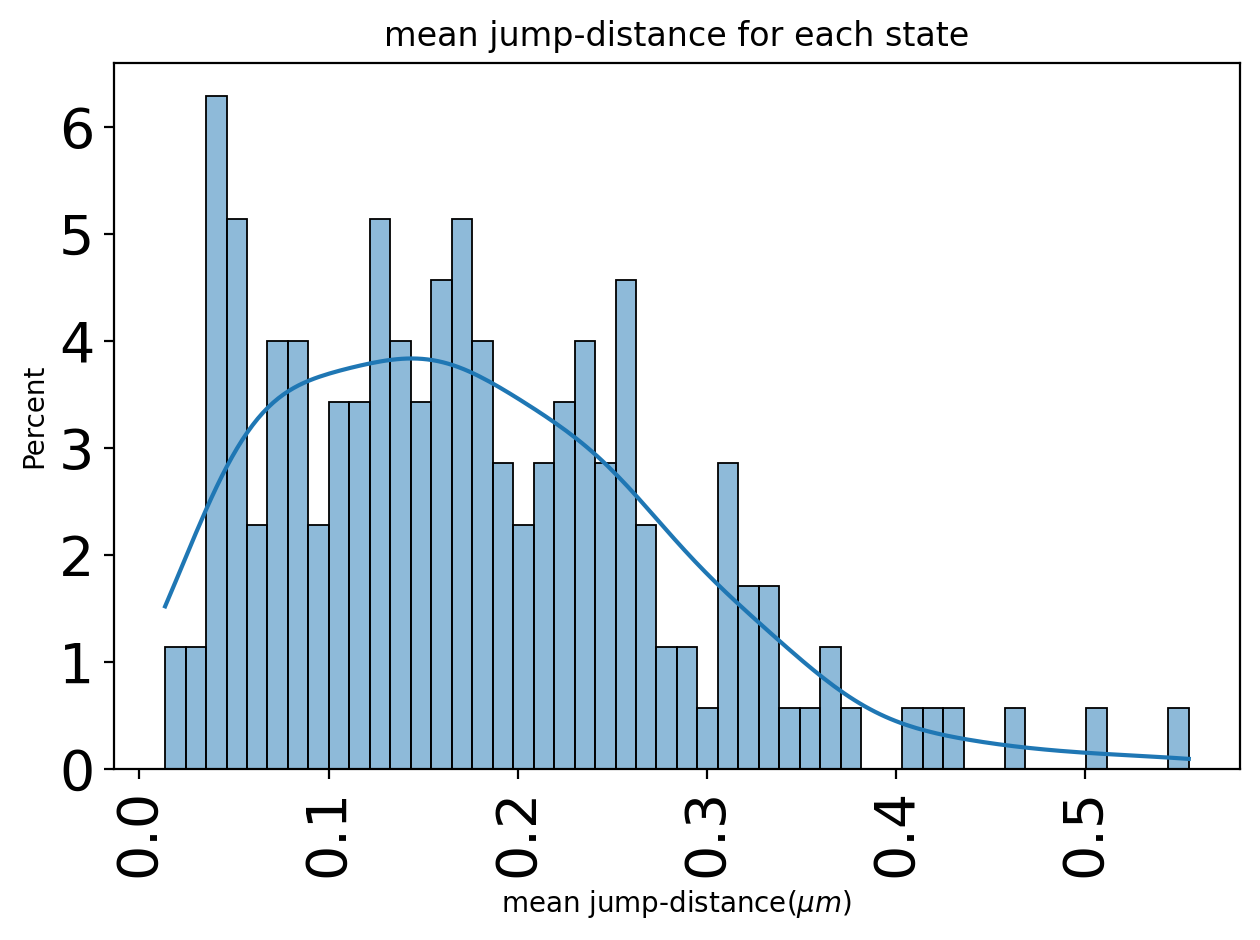

In [6]:
#p1: histogram with kde(kernel density estimation) plot of mean jump distance grouped by state.
plt.figure(f'p1', dpi=figure_resolution_in_dpi)
p1 = sns.histplot(analysis_data1, x=f'mean_jump_d', stat='percent', bins=number_of_bins, kde=True)
p1.set_xlabel(r'mean jump-distance($\mu m$)')
p1.set_title(f'mean jump-distance for each state')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

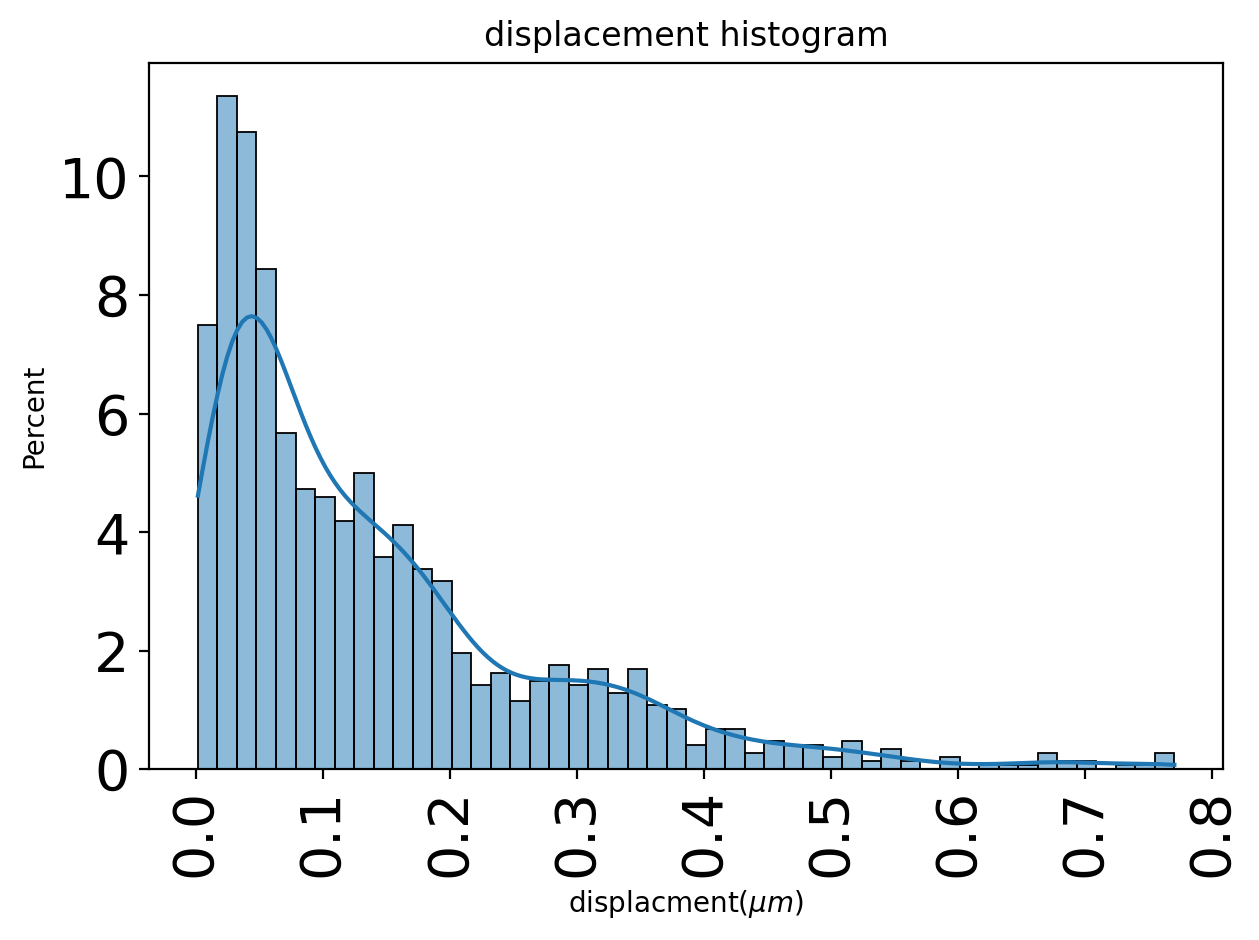

In [7]:
#p2: displacement histogram
plt.figure(f'p2', dpi=figure_resolution_in_dpi)
p2 = sns.histplot(data=analysis_data2, x='displacements', stat='percent', bins=number_of_bins, kde=True)
p2.set_title(f'displacement histogram')
p2.set_xlabel(r'displacment($\mu m$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

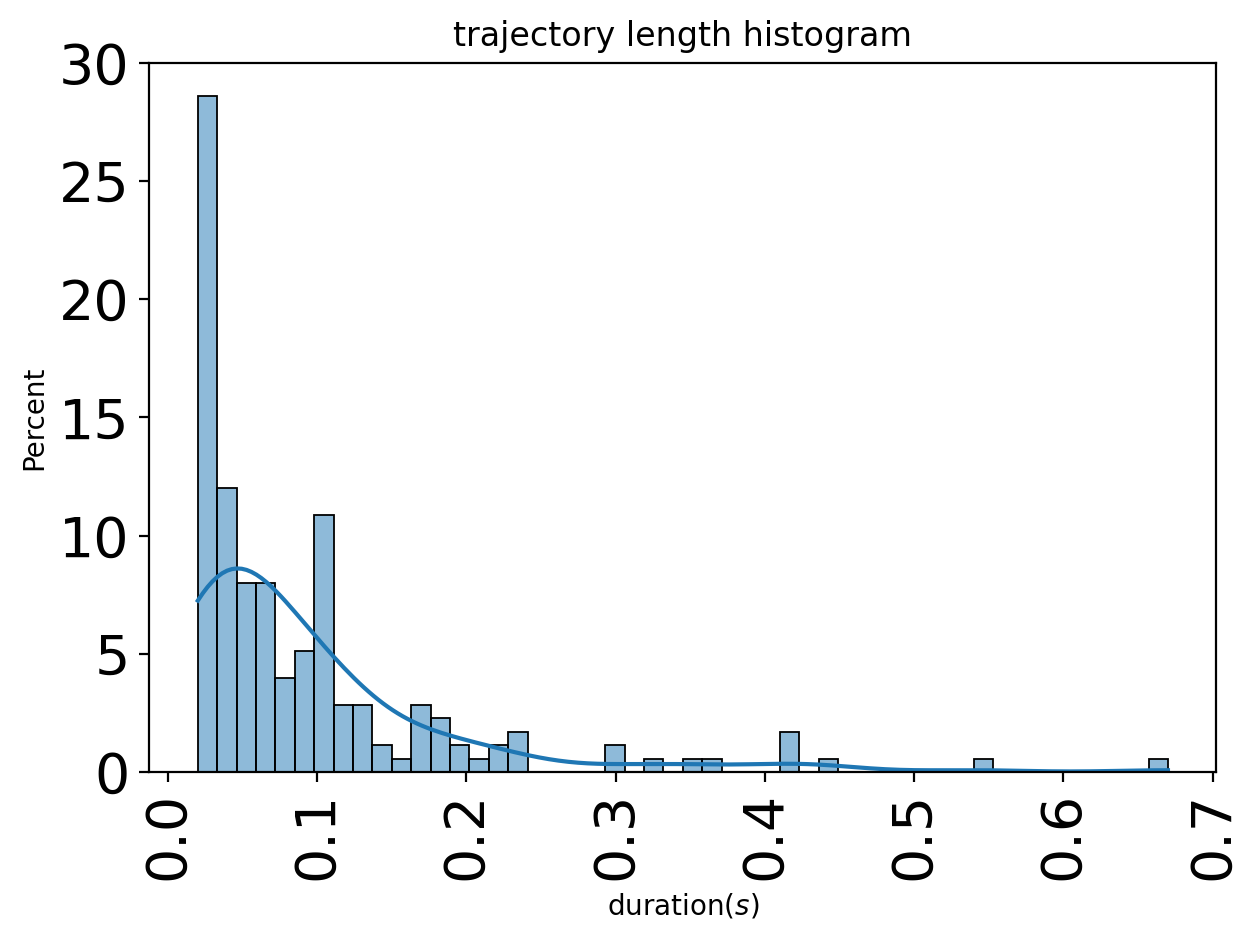

In [8]:
#p3: trajectory length(sec) histogram
plt.figure(f'p3', dpi=figure_resolution_in_dpi)
p3 = sns.histplot(data=analysis_data1, x='duration', stat='percent', bins=number_of_bins, kde=True)
p3.set_title(f'trajectory length histogram')
p3.set_xlabel(r'duration($s$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

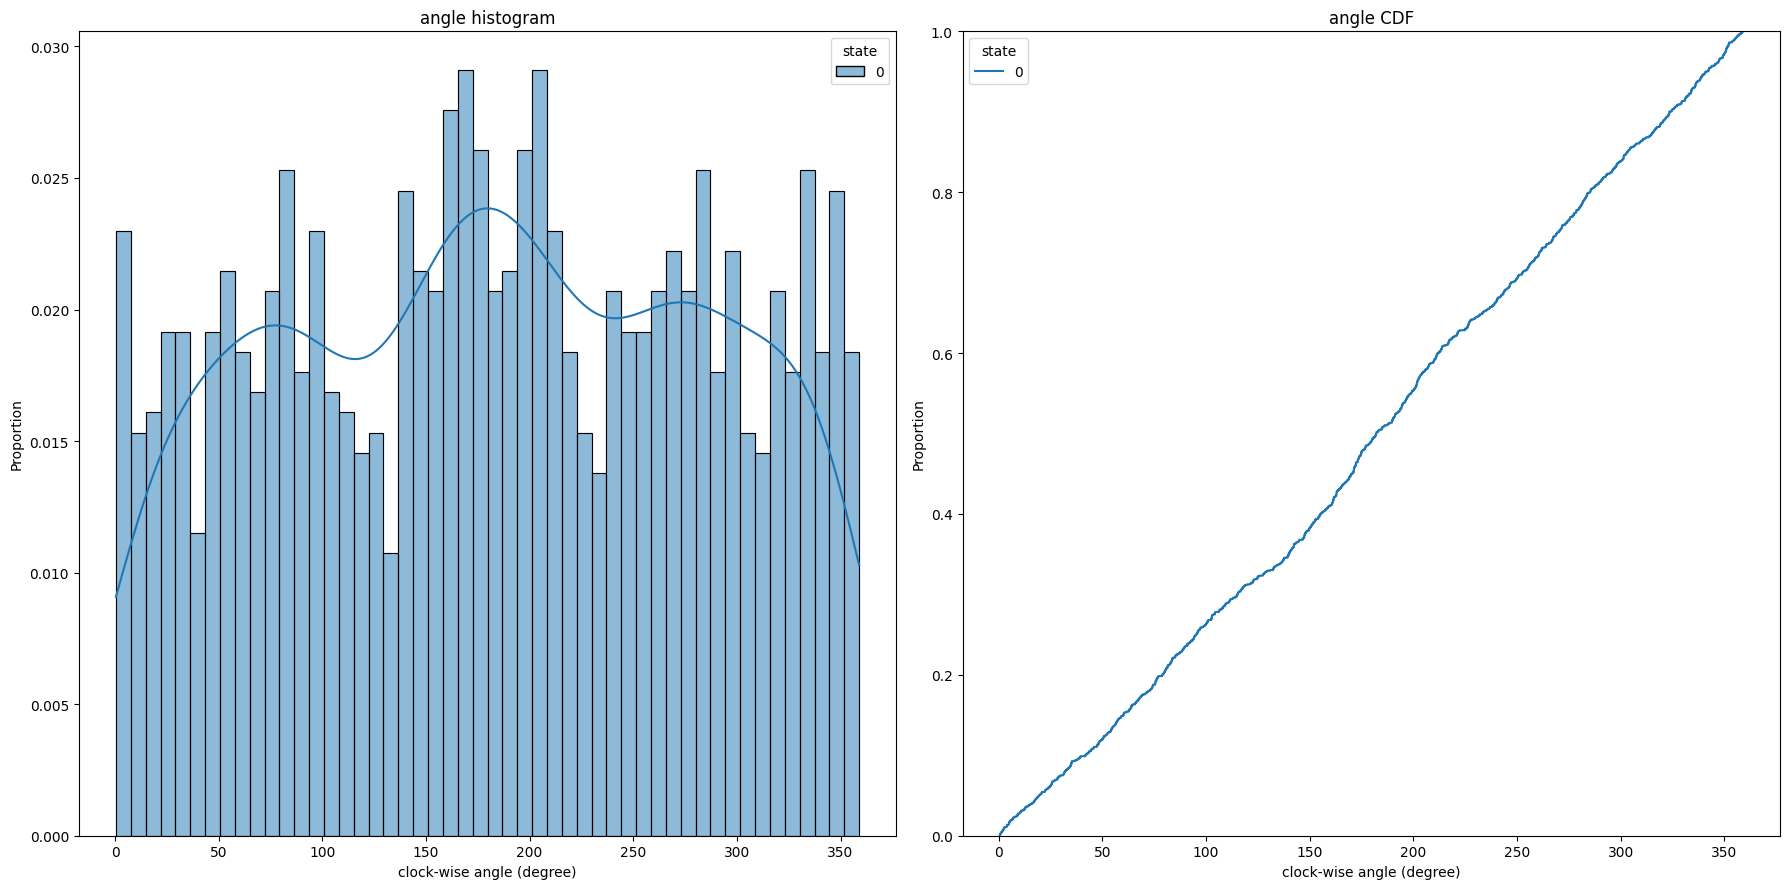

In [9]:
#p4: angles histogram
fig, axs = plt.subplots(1, 2, num=f'p13', figsize=(18, 9))
sns.histplot(data=analysis_data3, x='angles', stat='proportion', hue='state', common_norm=False, bins=number_of_bins, kde=True, ax=axs[0], kde_kws={'bw_adjust': 1})
sns.ecdfplot(data=analysis_data3, x='angles', stat='proportion', hue='state', ax=axs[1])
axs[0].set_title(f'angle histogram')
axs[0].set_xlabel(r'clock-wise angle (degree)')
axs[1].set_title(f'angle CDF')
axs[1].set_xlabel(r'clock-wise angle (degree)')
plt.tight_layout()

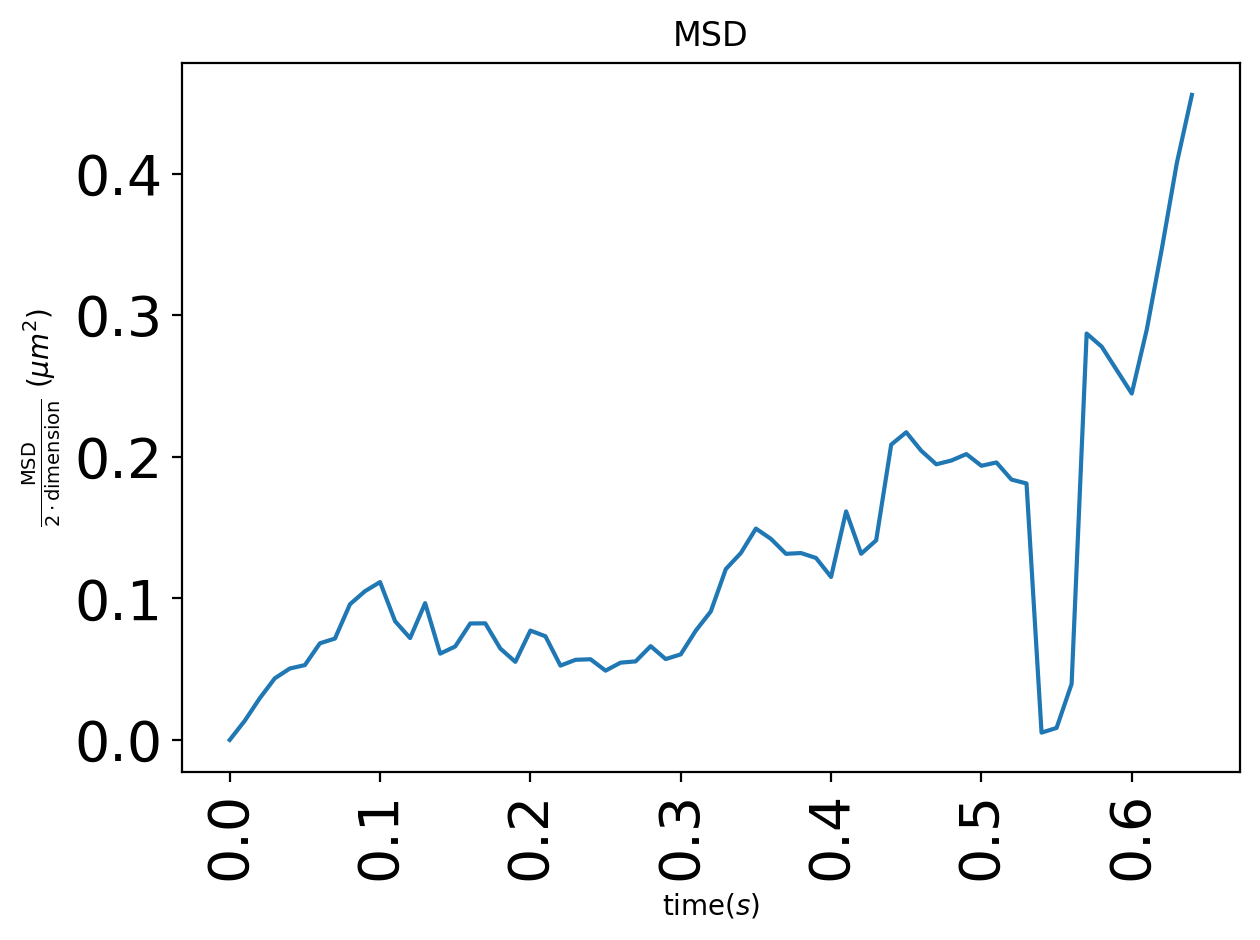

In [10]:
#p5: MSD
plt.figure(f'p5', dpi=figure_resolution_in_dpi)
p4 = sns.lineplot(data=msd, x=msd['time'], y=msd['mean'])
p4.set_title(f'MSD')
p4.set_xlabel(r'time($s$)')
p4.set_ylabel(r'$\frac{\text{MSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

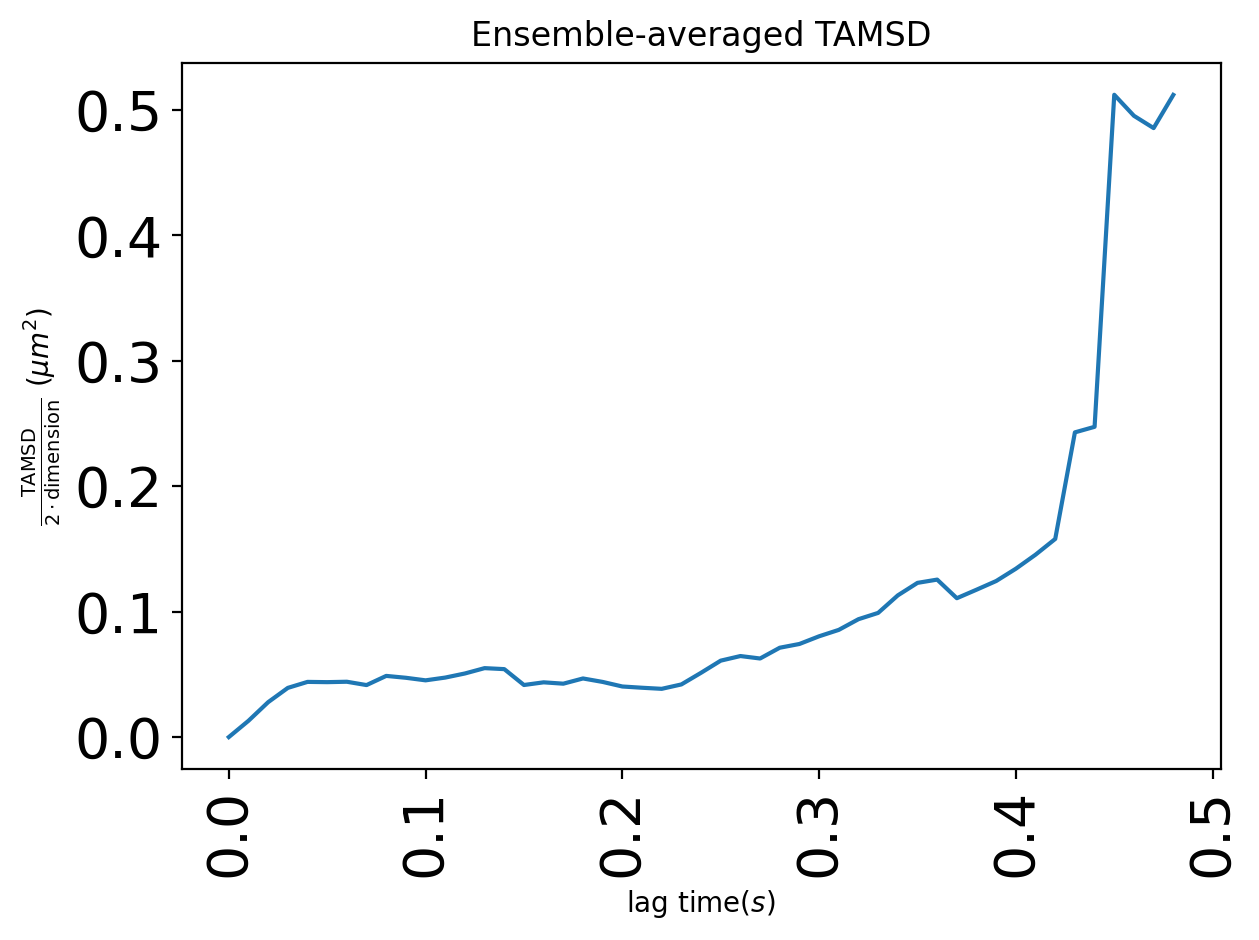

In [11]:
#p6: Ensemble-averaged TAMSD
plt.figure(f'p6', dpi=figure_resolution_in_dpi)
p5 = sns.lineplot(data=tamsd, x=tamsd['time'], y=tamsd['mean'])
p5.set_title(f'Ensemble-averaged TAMSD')
p5.set_xlabel(r'lag time($s$)')
p5.set_ylabel(r'$\frac{\text{TAMSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()